## Analysis of Influenza sequences from brbrc.org
by Duo peng  
  
This notebook analyzes the Influenza sequences downloaded from brbrc.org  

There are four sections:  
- Tally segments/genes
- Tally strains
- Tally gene, segment and subtypes
- Create a dataframe with segement, subtype and strain information for each downloaded sequence

Note: the dataframe from the last section is saved as a csv file and used in subsequent analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from utils import *
from pathlib import Path

## Tally segments/genes

In [2]:
df_sequences = pd.read_csv(Path.cwd().parent / '1.download_influenza_genomes' / 'Orthomyxoviridae.fna.Influenza.txt', sep='\t', header=None)
df_sequences.columns = ['sequence_ID', 'length', "description"]
num_sequences = df_sequences.shape[0]
print(f"The total number of influenza sequences (genomes/segments/genes) is {df_sequences.shape[0]:,} ")
#print(f"first 5 sequences:\n{df_sequences.head()}")


The total number of influenza sequences (genomes/segments/genes) is 1,046,743 


### plot the distribution of segments/genes lengths

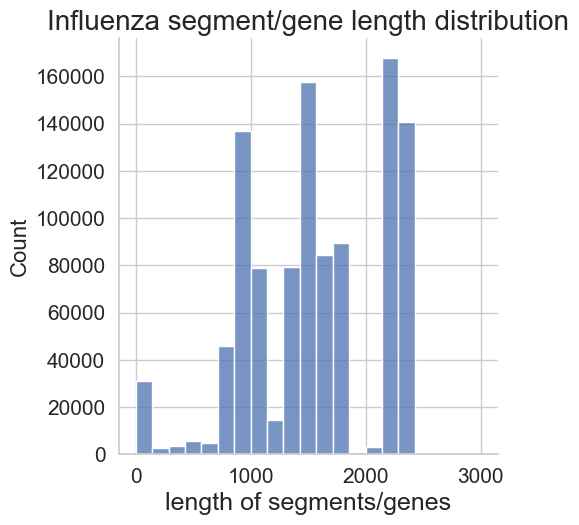

In [3]:
## plot the distribution of sequence lengths
sns.set(style="whitegrid")
sns.displot(df_sequences, x="length", kind="hist", binrange=[1, 3000], bins = 21)
plt.title("Influenza segment/gene length distribution", fontsize = 20)
plt.xlabel('length of segments/genes', fontsize=18)
plt.ylabel('Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize= 15)
plt.show()

## Tally strains

In [4]:
# go through each sequence description and extract strain name and subtype
strain_gene_dict = {}
strain_seg_dict = {}

for idx, row in df_sequences.iterrows():
    strain_name, subtype, gene_name, seg_name = extract_genome_strain(row['description'])
    if not strain_name is None and len(strain_name) > 7:
        if not gene_name is None:
            strain_gene_dict = dict_update(strain_gene_dict, strain_name, gene_name, 1)
        if not seg_name is None:
            strain_seg_dict = dict_update(strain_seg_dict, strain_name, seg_name, 1)

In [5]:
# parse strain names
unique_strains = set(list(strain_seg_dict.keys()) + list(strain_gene_dict.keys()))
strains_with_all_seg = []
strains_with_all_seg_dict = {}
for i in (list(unique_strains)):
    if i in strain_seg_dict and len(strain_seg_dict[i]) >= 8:
        strains_with_all_seg.append(i)
        strains_with_all_seg_dict[i] = strain_seg_dict[i]
    elif i in strain_gene_dict and len(strain_gene_dict[i]) >= 8:
        strains_with_all_seg.append(i)
        strains_with_all_seg_dict[i] = strain_gene_dict[i]


In [6]:
print(f"The number of strains is: {len(unique_strains)}")


The number of strains is: 176708


In [7]:
print(f"The number of strains with all 8 segments is: {len(strains_with_all_seg)}")


The number of strains with all 8 segments is: 79356


## Tally gene,segment and subtypes

In [8]:
# parse segment names and gene names
# convert genes to segments
segments = {} #lookup dictionary, format: {segment_name: [sequence_ID1, sequence_ID2, ...],  segment_name2: [sequence_ID1, sequence_ID2, ...} 
genes = {} #lookup dictionary, format: {gene_name: [sequence_ID1, sequence_ID2, ...],  gene_name2: [sequence_ID1, sequence_ID2, ...}
subtypes = {} #lookup dictionary, format: {subtype: [sequence_ID1, sequence_ID2, ...],  subtype2: [sequence_ID1, sequence_ID2, ...}
failed_count = 0
seg_count = 0
gene_count = 0
subtype_count = 0
total_count = 0
for idx, row in df_sequences.iterrows():
    total_count += 1
    desc = row["description"]
    # parse segment name
    segment_name = parse_segment_name(desc)
    if segment_name:
        seg_count += 1
        segments = update_dict(mydict = segments, key = segment_name, value = row["sequence_ID"])
    else:
        gene_name = parse_gene_name(desc)
        if gene_name:
            gene_count += 1
            genes = update_dict(mydict = genes, key = gene_name, value = row["sequence_ID"])
            segment_name = gene_name_collapse[gene_name]
            segments = update_dict(mydict = segments, key = segment_name, value = row["sequence_ID"])
        else:
            failed_count += 1
    #parse subtypes
    subtype_name = parse_subtypes(desc)
    if subtype_name:
        subtype_count += 1
        subtypes = update_dict(mydict = subtypes, key = subtype_name, value = row["sequence_ID"])

print(f"Out of of {total_count} sequences:")
print(f"{failed_count} sequences have no segment names and no gene names")
print(f"{seg_count} sequences have segment names")
print(f"{gene_count} sequences have gene names")
print(f"{subtype_count} sequences have subtypes")

Out of of 1046743 sequences:
36470 sequences have no segment names and no gene names
775224 sequences have segment names
235049 sequences have gene names
824097 sequences have subtypes


In [9]:
# print the number of sequences for each segment
def get_list_lengths(dictionary, key_name_to_print,sorty_by_key=True):
    """produce a dictionary of segment name and the ID of seqs assigned to each segment
    """
    if sorty_by_key:
        sorted_items = sorted(dictionary.items(), key=lambda x: x[0])
        for key, value in sorted_items:
            length = len(value)
            print(f"{key_name_to_print}: {key}, sequence count: {length}")
        return sorted_items
    else:
        lengths = [(key, len(value)) for key, value in dictionary.items()]
        sorted_lengths = sorted(lengths, key=lambda x: x[1])
        for key, length in sorted_lengths:
            print(f"{key_name_to_print}: {key}, sequence count: {length}")
        return sorted_lengths

# #sort the printout by seq count
# get_list_lengths(segments, "Segment", sorty_by_key=False)
# print("\n") 
    
segment_dict = get_list_lengths(segments, "Segment", sorty_by_key=True) 
segment_dict = {key: len(value) for key, value in segment_dict} # convert to a dictionary of segment name and the number of seqs assigned to each segment

segmentwise_df = pd.DataFrame.from_dict(segment_dict, orient='index', columns=["sequence_count"]) # make a dataframe of segment name and the number of seqs assigned to each segment

Segment: 1, sequence count: 106546
Segment: 2, sequence count: 104760
Segment: 3, sequence count: 105677
Segment: 4, sequence count: 204164
Segment: 5, sequence count: 107978
Segment: 6, sequence count: 145858
Segment: 7, sequence count: 123048
Segment: 8, sequence count: 112242


In [10]:
# print the number of sequences for each subtype
# get_list_lengths(subtypes, "Subtype", sorty_by_key=False)
# print("\n")
Subtype_dict = get_list_lengths(subtypes, "Subtype", sorty_by_key=True)
Subtype_dict = {key: len(value) for key, value in Subtype_dict} # convert to a dictionary of segment name and the number of seqs assigned to each segment

subtypewise_df = pd.DataFrame.from_dict(Subtype_dict, orient='index', columns=["sequence_count"]) # make a dataframe of segment name and the number of seqs assigned to each segment

Subtype: H0N1, sequence count: 1
Subtype: H1N1, sequence count: 235211
Subtype: H1N2, sequence count: 36121
Subtype: H1N3, sequence count: 791
Subtype: H1N4, sequence count: 80
Subtype: H1N5, sequence count: 110
Subtype: H1N6, sequence count: 349
Subtype: H1N7, sequence count: 101
Subtype: H1N8, sequence count: 372
Subtype: H1N9, sequence count: 555
Subtype: H2N1, sequence count: 495
Subtype: H2N2, sequence count: 1913
Subtype: H2N3, sequence count: 2402
Subtype: H2N4, sequence count: 120
Subtype: H2N5, sequence count: 338
Subtype: H2N6, sequence count: 73
Subtype: H2N7, sequence count: 473
Subtype: H2N8, sequence count: 144
Subtype: H2N9, sequence count: 736
Subtype: H3N1, sequence count: 1463
Subtype: H3N2, sequence count: 322940
Subtype: H3N3, sequence count: 337
Subtype: H3N4, sequence count: 55
Subtype: H3N5, sequence count: 208
Subtype: H3N6, sequence count: 3011
Subtype: H3N7, sequence count: 197
Subtype: H3N8, sequence count: 25131
Subtype: H3N9, sequence count: 120
Subtype: H4

In [11]:
subtypewise_df

,sequence_count
H0N1,1
H1N1,235211
H1N2,36121
H1N3,791
H1N4,80
...,...
H9N5,285
H9N6,100
H9N7,94
H9N8,60


## Create a dataframe with segement, subtype and strain information for each downloaded sequence

In [12]:
df_sequences["spp"] = df_sequences["description"].apply(parse_spp)
df_sequences["segment"] = df_sequences.apply(desc2seg, axis = 1)
df_sequences["subtype"] = df_sequences.apply(desc2subtype, axis = 1)
df_sequences["strain"] = df_sequences.apply(desc2strain, axis = 1)

In [13]:
outdir = Path.cwd() / "output"
outdir.mkdir(parents=True, exist_ok=True)

# write the dataframe to file
df_sequences.to_csv(outdir / "Influenza_sequence_description_parsed.txt", index=False, sep="\t")

# write unique strain names to file
df_sequences["strain"].unique().tofile(outdir / "unique_strain_names.txt", sep="\n", format="%s")

In [14]:
# view the dataframe
df_sequences

,sequence_ID,length,description,spp,segment,subtype,strain
0,4BBL_Y,308,4BBL_Y Cryo-electron microscopy reconstructi...,influenza a virus,5,None,None
1,4BBL_Z,308,4BBL_Z Cryo-electron microscopy reconstructi...,influenza a virus,5,None,None
2,4WRT_R,18,4WRT_R Crystal structure of Influenza B poly...,influenza b virus,None,None,None
3,4WRT_V,14,4WRT_V Crystal structure of Influenza B poly...,influenza b virus,None,None,None
4,4WSA_R,18,4WSA_R Crystal structure of Influenza B poly...,influenza b virus,None,None,None
...,...,...,...,...,...,...,...
1046738,Z54289,1711,Z54289 Influenza A virus (Mongolia/162/91 (H...,influenza a virus,4,H1N1,Mongolia/162/91
1046739,Z54290,1518,Z54290 Influenza A virus (Mongolia/231/85 (H...,influenza a virus,5,H1N1,Mongolia/231/85
1046740,Z54291,1518,Z54291 Influenza A virus (Mongolia/153/88 (H...,influenza a virus,5,H1N1,Mongolia/153/88
1046741,Z54292,1518,Z54292 Influenza A virus (A/Mongolia/111/91 ...,influenza a virus,5,H1N1,A/Mongolia/111/91
